# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

Also note that the code in this Notebook can take many minutes or even hours to run. This is the case for most NLP research these days, and it's a good opportunity to start thinking about how to manage high-compute workloads, such as running code on small samples to test it, loading datafiles in [chunks](https://stackoverflow.com/a/25962187), or [multiprocessing](https://en.wikipedia.org/wiki/Multiprocessing).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color="blue">*Pitch Your Project*</font>

<font color="blue">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).</font>

### ***What?***
For our project, Michael Plunkett and I will analyze congressional and Supreme Court
abortion-related legislation. Particularly for the congressional legislation, we will explore
all legislation from 1973 until 2024. We sourced this legislation from the congress.gov
legislation search, where we filtered for any legislation within this period that could
have become bills and included the following keywords in the bill text or summary:
'abortion,' 'reproduction,' or 'reproductive health care.' For the SCOTUS abortion
legislation, we targeted SCOTUS decisions outlined on supreme.justia.com, which provides a
list of abortion-relevant SCOTUS decisions from 1965-2022. Through this analysis, we
plan to uncover the ways that the legislative abortion discourse has changed over time and
the prominent congressional bills that have occurred throughout subsequent pieces of legislation.
We will supplement this analysis with legislation in its political history by taking
note of the political affiliations of congress members, SCOTUS justices, and the presidency.

Chanteria Milner: [Link](https://github.com/chanteriam)
Michael Plunkett: [Link](https://github.com/michplunkett)\
Congressional source: [Link](https://www.congress.gov/advanced-search/legislation?congressGroup%5B%5D=0&congresses%5B%5D=118&congresses%5B%5D=117&congresses%5B%5D=116&congresses%5B%5D=115&congresses%5B%5D=114&congresses%5B%5D=113&congresses%5B%5D=112&congresses%5B%5D=111&congresses%5B%5D=110&congresses%5B%5D=109&congresses%5B%5D=108&congresses%5B%5D=107&congresses%5B%5D=106&congresses%5B%5D=105&congresses%5B%5D=104&congresses%5B%5D=103&congresses%5B%5D=102&congresses%5B%5D=101&congresses%5B%5D=100&congresses%5B%5D=99&congresses%5B%5D=98&congresses%5B%5D=97&congresses%5B%5D=96&congresses%5B%5D=95&congresses%5B%5D=94&congresses%5B%5D=93&legislationNumbers=&restrictionType=field&restrictionFields%5B%5D=allBillTitles&restrictionFields%5B%5D=summary&summaryField=billSummary&enterTerms=%22reproductive+health+care%22%2C+%22reproduction%22%2C+%22abortion%22&legislationTypes%5B%5D=hr&legislationTypes%5B%5D=hjres&legislationTypes%5B%5D=s&legislationTypes%5B%5D=sjres&public=true&private=true&chamber=all&actionTerms=&legislativeActionWordVariants=true&dateOfActionOperator=equal&dateOfActionStartDate=&dateOfActionEndDate=&dateOfActionIsOptions=yesterday&dateOfActionToggle=multi&legislativeAction=Any&sponsorState=One&member=&sponsorTypes%5B%5D=sponsor&sponsorTypeBool=OR&dateOfSponsorshipOperator=equal&dateOfSponsorshipStartDate=&dateOfSponsorshipEndDate=&dateOfSponsorshipIsOptions=yesterday&committeeActivity%5B%5D=0&committeeActivity%5B%5D=3&committeeActivity%5B%5D=11&committeeActivity%5B%5D=12&committeeActivity%5B%5D=4&committeeActivity%5B%5D=2&committeeActivity%5B%5D=5&committeeActivity%5B%5D=9&satellite=null&search=&submitted=Submitted)
SCOTUS source: [Link](https://supreme.justia.com/cases-by-topic/abortion-reproductive-rights/)

### ***Why?***
This analysis, in general, will give us an understanding of how abortion discourse has changed over time, and specifically, what arguments were used in the passing of the 1973 Roe v. Wade decision--and with it, the assertion of the constitutional right to abortion and its eventual reversal in the 2022 Dobbs v. Jackson decision. From this, we will be able to uncover what political mechanisms were at play that enabled this regression in legislation, and how such significant cases went on to influence congressional legislation that followed. The average person will, in general, be able to understand how sensitive practices are discussed in the political sphere and what aspects in particular are targeted for protection or not. Moreover, this analysis will allow individuals who want to write reproductive healthcare legislation to understand what arguments are more likely to work over others within certain political contexts.

### ***How?***
As stated, our project aims to analyze the evolution of abortion discourse in U.S. legislation, particularly between the landmark Roe v. Wade (1973) and Dobbs v. Jackson (2022) decisions, which established and then rescinded abortion as a constitutional right, respectively. We have assembled a dataset of congressional legislation from 1973 to 2024, alongside a dataset of opinions from 13 pivotal Supreme Court cases. The legislative measures generally either attempt to protect the right to abortion or seek to ban it.

Firstly, we will apply a clustering method to categorize the congressional legislation into three groups: pro-abortion, anti-abortion, and unrelated (noise). We will review and discard the unrelated legislation. Subsequently, we will employ structural topic modeling on the two relevant clusters to explore the evolution of arguments for and against abortion over time. Due to the absence of specific dates on the legislation, we will use the congressional session number as a temporal reference.

Furthermore, we will perform a qualitative and quantitative analysis to compare convergent and divergent themes between the two models. This will be followed by a comprehensive structural topic modeling of the clustered data.

Regarding the Supreme Court cases, we plan to use them as benchmarks to categorize legislative sessions. For example, if a case on abortion was adjudicated in 2010 and another in 2015, we would assess the semantic, tonal, and lexical similarities among all congressional legislation enacted between those years. Our hypothesis posits that the substance of Supreme Court opinions significantly influences abortion-related legislation from the time of their issuance until a subsequent opinion emerges. We will also determine which opinions, aside from Roe and Dobbs, exert the most influence on legislative documents.

In a broader analysis, we aim to identify terms that are predominantly used in Supreme Court opinions and legislative texts, discounting procedural terminology prior to the analysis. This will highlight the distinct legal and authoritative contexts within which these discussions occur. Legislators typically seek to persuade their peers, while justices are more inclined to articulate informative opinions. We anticipate that these differing objectives will be reflected in the language used.

Overall, this analysis is expected to yield insights into the thematic development of abortion legislation and its interplay with Supreme Court rulings.

## <font color="Blue">*Pitch Your Sample*</font>

<font color="Blue">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

### ***Which (words)?***
Starting in the early 1970s with the adoption of the Hyde Amendment, the amendment that prevented federal funding of abortions through Medicaid, anti-abortion advocates have attempted to reverse the Roe decision through a multitude of avenues. These efforts eventually culminated in the Dobbs v. Jackson decision in 2022. The elevation of the Dobbs v. Jackson case was not something that happened by random chance but instead was the result of decades of concerted efforts by anti-abortion advocates, think tanks, and political action committees. In our project, we intend to see how the social game of these groups probing for judicial vulnerabilities changed over time and the language that made up those attempts. The actors in this study are primarily the congressional legislators and supreme court justices, whom we will study via their decisions and proposed pieces of legislation, respectively. This analysis will give us a direct look into the terminology used to overturn Roe in its successful and unsuccessful cases.

Our analysis in this project will undoubtedly give us some valuable insights, but it will not allow us to create the entire picture. The sources we are using only capture the result of the efforts made by anti-abortion advocates, etc. A more complete design of this analysis would take documents from conservative think tanks like the Heritage Foundation, Family Research Council, Moral Majority, etc. Taking in documents from these organizations and other similarly minded ones would give us insight into the documents upstream from the legislative and decision documents we're currently assessing. To scale this project up for a high-profile journal, we could get documents from those organizations listed and look for similarities between them and the documents we're currently examining to see the complete evolution of the language from its initial planning to attempts at federal implementation.

## Set Up

In [2]:
%pip install virtualenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 46.4 MB/s eta 0:00:00


In [3]:
!virtualenv venv

created virtual environment CPython3.10.12.final.0-64 in 1268ms
  creator CPython3Posix(dest=/content/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [4]:
!source /content/venv/bin/activate

In [5]:
# Installations
%pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
%pip install fasttext
%pip install cython
%pip install ksvd

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-e3p26lmg
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-e3p26lmg
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━

In [6]:
# data
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Image
%matplotlib inline

# sklearn
import sklearn.metrics.pairwise
import sklearn.manifold
import sklearn.decomposition
from sklearn.metrics.pairwise import cosine_similarity

# gensim
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors, Word2Vec
from gensim import corpora, models, similarities
from gensim.test.utils import datapath

# models
import fasttext
from ksvd import ApproximateKSVD
from tqdm import tqdm
tqdm.pandas()

# misc
import lucem_illud
import re, string, cython, requests, nltk, copy, pickle, math
from random import seed, sample
import os
import os.path
import ast

## Helper Functions

In [7]:
# From the homework notebook
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model.wv[x]) for x in positives]) - sum([normalize(model.wv[y]) for y in negatives])
    return diff

In [8]:
# Plotting
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [9]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

In [37]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = calc_syn0norm(in_base_embed)
    # other_vecs = calc_syn0norm(in_other_embed)
    base_vecs= [in_base_embed.wv.get_vector(w,norm=True) for w in set(in_base_embed.wv.index_to_key)]
    other_vecs= [in_other_embed.wv.get_vector(w,norm=True) for w in set(in_other_embed.wv.index_to_key)]

    # just a matrix dot product with numpy
    m = np.array(other_vecs).T.dot(np.array(base_vecs))
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors =(np.array(other_vecs)).dot(ortho)
    return other_embed

In [35]:
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count")  + m2.wv.get_vecattr(w, "count") ,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        new_arr = [m.wv.get_vector(w,norm=True) for w in common_vocab]

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i={}
        for new_index,word in enumerate(common_vocab):
            new_vocab.append(word)
            k2i[word]=new_index
        m.wv.index_to_key=new_vocab
        m.wv.key_to_index=k2i
        m.wv.vectors=np.array(new_arr)

    return (m1,m2)

In [64]:
def compareModels(df, category, text_column_name='normalized_sents', sort=True):
    """Prepare embeddings and align them."""
    # Generate raw embeddings
    embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))

    # Align embeddings
    embeddings_aligned = {}
    base_cat = cats[0]  # Use the first category as the base for alignment
    for cat in cats:
        if cat == base_cat:
            embeddings_aligned[cat] = embeddings_raw[cat]
        else:
            # Align current category's embedding to the base category's embedding
            embeddings_aligned[cat] = smart_procrustes_align_gensim(embeddings_raw[base_cat], embeddings_raw[cat])
    return embeddings_raw, embeddings_aligned


In [65]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

In [75]:
def getDivergenceDF(word, embeddingsDict):
    # """Calculate pairwise divergence for a specific word across different embeddings."""
    cats = sorted(embeddingsDict.keys())  # Sorted categories, e.g., congress numbers
    # Initialize a square DataFrame with zeros
    df = pd.DataFrame(np.zeros((len(cats), len(cats))), index=cats, columns=cats)

    for i, cat_outer in enumerate(cats):
        for j, cat_inner in enumerate(cats):
            if i == j:
                # Divergence with itself should be 0
                df.iloc[i, j] = 0
            else:
                # Calculate cosine similarity for different congress embeddings
                vector_outer = embeddingsDict[cat_outer].wv[word]
                vector_inner = embeddingsDict[cat_inner].wv[word]
                similarity = sklearn.metrics.pairwise.cosine_similarity(
                    np.expand_dims(vector_outer, axis=0),
                    np.expand_dims(vector_inner, axis=0))[0, 0]
                divergence = np.abs(1 - similarity)
                df.iloc[i, j] = divergence

    return df

In [77]:
def verify_embeddings(embeddingsDict, word):
    """Check if any embedding vector for 'word' is invalid or significantly different."""
    for cat, model in embeddingsDict.items():
        if word not in model.wv:
            print(f"Warning: '{word}' not found in embeddings for category '{cat}'.")
        else:
            vector = model.wv[word]
            if np.all(vector == 0):
                print(f"Warning: Embedding vector for '{word}' in category '{cat}' is all zeros.")

In [110]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    # Assuming cats[0] is the category you want to compare others against
    base_embed = embeddingsDict[cats[0]]
    for cat in cats[1:]:  # Skip the first category since it's the base
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(
                np.expand_dims(base_embed.wv[word], axis=0),
                np.expand_dims(embeddingsDict[cat].wv[word], axis=0)
            )[0,0])
        except:
            # This except block silently ignores errors, consider logging or handling them.
            pass
    return np.mean(dists)

In [111]:
def findMostDivergent(embeddingsDict, orig_key):
    # Directly access the Word2Vec model for the original key
    original_words = embeddingsDict[orig_key].wv.index_to_key
    for embed_key, embed in embeddingsDict.items():
        original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key=lambda x: x[1], reverse=True)

In [17]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [18]:
# get random indices
def random_indices(df_len, num_indices):
    """
    Generate a list of random indices.

    returns: list of random indices
    """
    random_indices = np.random.choice(df_len, num_indices, replace=False)
    random_indices = list(random_indices)
    random_indices.sort()

    return random_indices

## Data Loading

In [19]:
outpath = '/content/drive/MyDrive/Colab Notebooks/soci40133-homeworks/data/'

In [20]:
# loading congressional data
congress_fp = '/content/drive/MyDrive/Colab Notebooks/soci40133-homeworks/data/congress_legislation_tokenized_sents.csv'
congress_df = pd.read_csv(congress_fp)
congress_df = congress_df.iloc[:, 1:]
congress_df.head(10)

,congress_num,legislation number,title,cleaned_text,tokenized_sents,normalized_sents
0,118,H.R. 2907,Let Doctors Provide Reproductive Health Care Act,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
1,118,S. 1297,Let Doctors Provide Reproductive Health Care Act,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
2,118,H.R. 4901,Reproductive Health Care Accessibility Act,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
3,118,S. 2544,Reproductive Health Care Accessibility Act,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
4,118,H.R. 4147,Reproductive Health Care Training Act of 2023,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
5,118,S. 2024,Reproductive Health Care Training Act of 2023,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
6,118,H.R. 1723,Abortion is Health Care Everywhere Act of 2023,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
7,118,S. 929,Abortion is Health Care Everywhere Act of 2023,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
8,118,H.R. 73,No Pro-Abortion Task Force Act,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."
9,118,H.R. 7,No Taxpayer Funding for Abortion and Abortion ...,Congressional Bills 118th Congress From the U....,"[['Congressional', 'Bills', '118th', 'Congress...","[['congressional', 'bills', 'congress', 'u.s',..."


### Tokenization

#### Congressional Legislation

In [21]:
# tokenize and normalize sentences -
# congress_df['tokenized_sents'] = congress_df['cleaned_text'].progress_apply(lambda x: [lucem_illud.word_tokenize(s, MAX_LEN=5000000) for s in lucem_illud.sent_tokenize(x)])

In [22]:
# convert string representations of lists into actual lists
congress_df['tokenized_sents'] = congress_df['tokenized_sents'].apply(lambda x: ast.literal_eval(x))
congress_df['normalized_sents'] = congress_df['normalized_sents'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# congress_df['normalized_sents'] = congress_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])

## <font color="blue">*Exercise 1*</font>

<font color="blue">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why?

<font color="blue">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

### Word2Vec: CBOW

#### Create model

In [ ]:
# congress_w2v = gensim.models.word2vec.Word2Vec(congress_df['normalized_sents'].sum(), sg=0)
congress_w2v = gensim.models.word2vec.Word2Vec.load(outpath + 'congress_w2v')

In [ ]:
print('"abortion" vector: ', congress_w2v.wv['abortion'][:10])
print('word at index 10: ', congress_w2v.wv.index_to_key[10])

"abortion" vector:  [-5.612072    0.3267288   1.0573627  -1.8947524   0.45254493 -1.1673063
 -4.5181017   2.3494272   4.0621276  -2.0734484 ]
word at index 10:  united


#### Similarity analysis

In [ ]:
# determine words most similar to abortion
congress_w2v.wv.most_similar('abortion')

[('abortions', 0.7421492338180542),
 ('sterilization', 0.5161693692207336),
 ('induced', 0.513643205165863),
 ('counsels', 0.5081219673156738),
 ('mother', 0.5071813464164734),
 ('mifepristone', 0.4809534251689911),
 ('banned', 0.4789317548274994),
 ('overt', 0.475414901971817),
 ('ask', 0.46699029207229614),
 ('heartbeat', 0.4632500112056732)]

In [ ]:
# determine words most similar to privacy
congress_w2v.wv.most_similar('privacy')

[('safeguards', 0.6213516592979431),
 ('confidentiality', 0.5741297006607056),
 ('retaliation', 0.5735570788383484),
 ('disclosure', 0.5724079608917236),
 ('protects', 0.5692076086997986),
 ('liberties', 0.5652321577072144),
 ('whistleblowers', 0.561862051486969),
 ('objectivity', 0.549883246421814),
 ('protections', 0.5464515089988708),
 ('safeguard', 0.5351738333702087)]

In [ ]:
# determine words most similar to protect
congress_w2v.wv.most_similar('protect')


[('preserve', 0.6159853339195251),
 ('protects', 0.5988128185272217),
 ('safeguard', 0.5983730554580688),
 ('protecting', 0.5832788348197937),
 ('precautions', 0.5482953190803528),
 ('prevent', 0.5470497012138367),
 ('desirable', 0.5434120297431946),
 ('avoid', 0.5338342189788818),
 ('perpetuity', 0.5301917195320129),
 ('save', 0.5149190425872803)]

In [ ]:
# determine words most similar to protect
congress_w2v.wv.most_similar('fetus')

[('mother', 0.7352379560470581),
 ('kills', 0.7236305475234985),
 ('detectable', 0.699462890625),
 ('overt', 0.6773601770401001),
 ('vaginally', 0.6765885353088379),
 ('heartbeat', 0.6730718612670898),
 ('infanticide', 0.6699287295341492),
 ('fetal', 0.6695061922073364),
 ('purposeful', 0.6525930166244507),
 ('spontaneous', 0.6525812149047852)]

In [ ]:
# determine words most similar to protect
congress_w2v.wv.most_similar('baby')

[('infant', 0.6874135732650757),
 ('clothing', 0.6389772295951843),
 ('diapers', 0.6380654573440552),
 ('perinatal', 0.6360554695129395),
 ('maternity', 0.6056177616119385),
 ('male', 0.578442394733429),
 ('whites', 0.5753489136695862),
 ('prenatal', 0.5669273734092712),
 ('otc', 0.5657860040664673),
 ('infants', 0.5636196136474609)]

In [ ]:
# determine words most similar to protect
congress_w2v.wv.most_similar('viability')

[('depends', 0.6091548204421997),
 ('heartbeat', 0.6060656905174255),
 ('bans', 0.5997994542121887),
 ('harmful', 0.5975643992424011),
 ('perception', 0.5965363383293152),
 ('predominately', 0.5941205620765686),
 ('cortex', 0.5852290391921997),
 ('rests', 0.5788933634757996),
 ('react', 0.5775757431983948),
 ('bias', 0.5721566677093506)]

In [ ]:
# determine words most similar to protect
congress_w2v.wv.most_similar('sexuality')

[('helps', 0.6756335496902466),
 ('paraprofessionals', 0.5968397259712219),
 ('postsecondary', 0.5871632695198059),
 ('abstinence', 0.5833180546760559),
 ('stem', 0.5776340961456299),
 ('counselling', 0.5730010867118835),
 ('breastfeeding', 0.5703728795051575),
 ('orientation', 0.5667834281921387),
 ('adulthood', 0.564831554889679),
 ('decisionmaking', 0.5629422068595886)]

In [ ]:
# determine words most similar to protect
congress_w2v.wv.most_similar('contraception')

[('infertility', 0.7181500196456909),
 ('postpartum', 0.6691842079162598),
 ('childbirth', 0.6659271717071533),
 ('screenings', 0.6615939140319824),
 ('infections', 0.6360496282577515),
 ('prenatal', 0.6351349949836731),
 ('childbearing', 0.6343631744384766),
 ('males', 0.6280860304832458),
 ('interventions', 0.6203569769859314),
 ('modern', 0.6197288036346436)]

In [ ]:
# find words most disimilar to
congress_w2v.wv.doesnt_match(['abortion', 'health', 'right', 'choice'])

'health'

In [ ]:
# use semantic equations to find words most analogous to [INSERT ANALOGY HERE]
# equation: X + Y - Z = ___ (woman is to abortion as man is to ___)
congress_w2v.wv.most_similar(positive=['woman', 'man'], negative = ['abortion'])



[('situation', 0.47203150391578674),
 ('reconstitution', 0.4673141539096832),
 ('halt', 0.45384863018989563),
 ('bleeding', 0.45343896746635437),
 ('ebola', 0.4478793442249298),
 ('innocent', 0.44371679425239563),
 ('confrontation', 0.4426037073135376),
 ('imminent', 0.44107818603515625),
 ('manmade', 0.4400501847267151),
 ('spreading', 0.43812209367752075)]

In [ ]:
# saving the model
congress_w2v.save(outpath + 'congress_w2v')

#### Visualization

In [ ]:
# select a random list of words
num_words = 50
indices = random_indices(len(congress_w2v.wv.index_to_key), num_words)
target_words = congress_w2v.wv.index_to_key[:num_words]

In [ ]:
# grab the vector representation of the words
words_sub_matrix = []
for word in target_words:
    words_sub_matrix.append(congress_w2v.wv[word])
words_sub_matrix = np.array(words_sub_matrix)
words_sub_matrix

array([[ 1.1388346 , -1.1721624 ,  1.7461935 , ..., -0.41372803,
         0.6833053 , -2.194777  ],
       [ 0.23770423, -1.5508502 ,  0.57159996, ...,  0.1626349 ,
         0.26618767,  0.22478934],
       [ 0.69627666, -0.59026873, -0.94444793, ...,  2.5725956 ,
         0.0770115 , -2.881043  ],
       ...,
       [ 0.01309244, -1.9653504 , -1.5769451 , ..., -0.5667724 ,
         1.4251993 , -6.06684   ],
       [-0.47486094,  1.0499866 ,  3.726806  , ...,  2.2157938 ,
        -1.5631832 ,  0.13062732],
       [ 5.850592  , -3.8639956 , -1.5480423 , ...,  2.5014067 ,
        -3.2338407 , -5.3928795 ]], dtype=float32)

In [ ]:
# dimensionality reduction
pca_words = sklearn.decomposition.PCA(n_components = 50).fit(words_sub_matrix)
reduced_PCA_data = pca_words.transform(words_sub_matrix)
#T-SNE is theoretically better, but you should experiment
tsne_words = sklearn.manifold.TSNE(n_components = 2).fit_transform(reduced_PCA_data)

##### TNSE

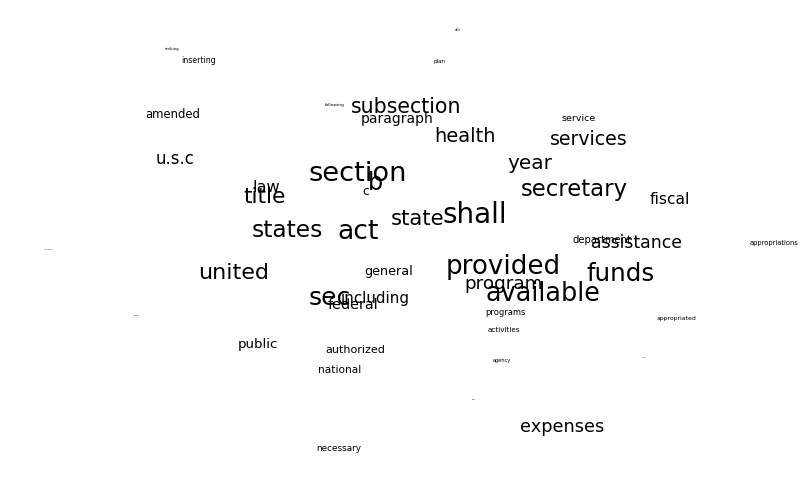

In [ ]:
# plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsne_words[:, 0], tsne_words[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(target_words):
    ax.annotate(word, (tsne_words[:, 0][i],tsne_words[:, 1][i]), size =  20 * (num_words - i) / num_words)
plt.xticks(())
plt.yticks(())
plt.show()

##### PCA

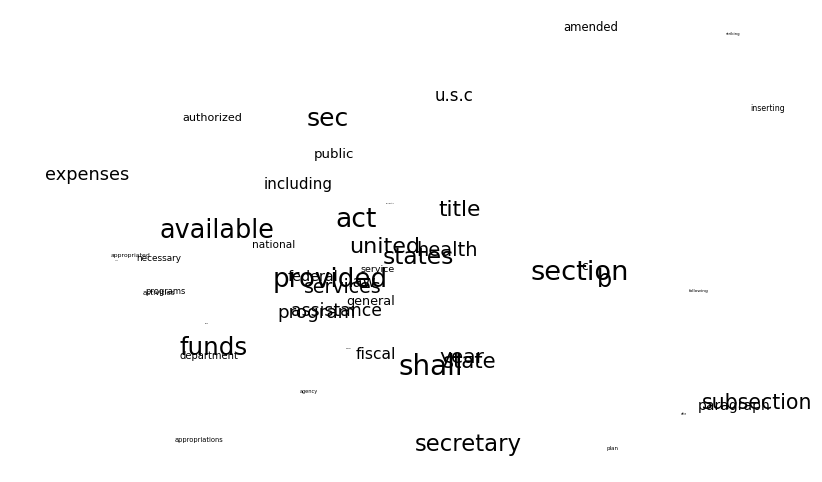

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_PCA_data[:, 0], reduced_PCA_data[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(target_words):
    ax.annotate(word, (reduced_PCA_data[:, 0][i],reduced_PCA_data[:, 1][i]), size =  20 * (num_words - i) / num_words)
plt.xticks(())
plt.yticks(())
plt.show()

### Word2Vec: Skip-grams

#### Create model

In [ ]:
congress_w2v_sg = gensim.models.word2vec.Word2Vec(congress_df['normalized_sents'].sum(), sg=1)

In [ ]:
print('"abortion" vector: ', congress_w2v_sg.wv['abortion'][:10])
print('word at index 10: ', congress_w2v_sg.wv.index_to_key[10])

"abortion" vector:  [-0.53932637  0.17423826  0.31645152 -0.23082948  0.3020377   0.39267945
 -0.3516492  -0.44962457  0.6443824  -0.10963786]
word at index 10:  united


In [ ]:
# saving the model
congress_w2v_sg.save(outpath + 'congress_w2v_sg')

#### Similarity analysis

In [ ]:
# determine words most similar to abortion
congress_w2v_sg.wv.most_similar('abortion')

[('abortions', 0.688012957572937),
 ('shame', 0.6427781581878662),
 ('sterilization', 0.6292738914489746),
 ('mother', 0.6243932843208313),
 ('dismemberment', 0.6082074046134949),
 ('gynecologic', 0.6006467342376709),
 ('woman', 0.591775119304657),
 ('stigmatize', 0.5888438820838928),
 ('disfavored', 0.5863617062568665),
 ('induced', 0.5828893780708313)]

In [ ]:
# determine words most similar to privacy
congress_w2v_sg.wv.most_similar('privacy')

[('liberties', 0.7063617706298828),
 ('trusteeships', 0.560242235660553),
 ('embarrass', 0.5574496984481812),
 ('intrusions', 0.5539625287055969),
 ('protect', 0.552689790725708),
 ('protects', 0.5472456216812134),
 ('rights', 0.5454851984977722),
 ('outweighs', 0.5431666374206543),
 ('procedural', 0.5405829548835754),
 ('552a', 0.5381172299385071)]

In [ ]:
# determine words most similar to protect
congress_w2v_sg.wv.most_similar('protect')

[('wholesomeness', 0.6591777801513672),
 ('thriving', 0.6202951669692993),
 ('enactments', 0.6086571216583252),
 ('jeopardize', 0.6043893098831177),
 ('preserve', 0.5930131673812866),
 ('protects', 0.5927300453186035),
 ('enjoyment', 0.5926752686500549),
 ('inadequacy', 0.5843029618263245),
 ('unnecessarily', 0.5823054909706116),
 ('anonymity', 0.5821221470832825)]

In [ ]:
# determine words most similar to protect
congress_w2v_sg.wv.most_similar('fetus')

[('vaginally', 0.7140504121780396),
 ('mother', 0.6866829991340637),
 ('stillbirth', 0.6513848304748535),
 ('detectable', 0.6506545543670654),
 ('conception', 0.6488375067710876),
 ('cremated', 0.6477338671684265),
 ('embryonic', 0.6425838470458984),
 ('emerges', 0.6257671117782593),
 ('womb', 0.6188725233078003),
 ('purposeful', 0.6103702187538147)]

In [ ]:
# determine words most similar to protect
congress_w2v_sg.wv.most_similar('baby')

[('diapers', 0.8069594502449036),
 ('bedding', 0.7042264938354492),
 ('bedside', 0.64555823802948),
 ('perinatal', 0.628898561000824),
 ('unwed', 0.6275528073310852),
 ('dressing', 0.6211807131767273),
 ('aborted', 0.6168179512023926),
 ('toileting', 0.6103485822677612),
 ('spontaneously', 0.6032295823097229),
 ('bathing', 0.5926228761672974)]

In [ ]:
# determine words most similar to protect
congress_w2v_sg.wv.most_similar('viability')

[('probability', 0.5915480256080627),
 ('endangers', 0.586832582950592),
 ('obstacle', 0.5640485882759094),
 ('indispensable', 0.5617852807044983),
 ('preserve', 0.5431272387504578),
 ('vitality', 0.5283582806587219),
 ('avert', 0.5219923853874207),
 ('feeling', 0.5111409425735474),
 ('hamper', 0.5099279880523682),
 ('recapitalize', 0.5093336701393127)]

In [ ]:
# determine words most similar to protect
congress_w2v_sg.wv.most_similar('sexuality')

[('helps', 0.7433207035064697),
 ('interpersonal', 0.7318593263626099),
 ('societal', 0.7220229506492615),
 ('friendships', 0.7151455879211426),
 ('prosperous', 0.709357738494873),
 ('multigenerational', 0.7055386304855347),
 ('attitudes', 0.7050474286079407),
 ('romantic', 0.6994750499725342),
 ('gifted', 0.6989432573318481),
 ('esteem', 0.6987380385398865)]

In [ ]:
# determine words most similar to protect
congress_w2v_sg.wv.most_similar('contraception')

[('infertility', 0.6632456183433533),
 ('stis', 0.6152341961860657),
 ('stigmatizing', 0.6078155040740967),
 ('diagnosing', 0.6060353517532349),
 ('wander', 0.599025547504425),
 ('stds', 0.598320722579956),
 ('breast', 0.5977168679237366),
 ('hpv', 0.5970675945281982),
 ('contraceptive', 0.5953567624092102),
 ('screenings', 0.5943633913993835)]

In [ ]:
congress_w2v_sg.wv.most_similar(positive=['woman', 'man'], negative = ['abortion'])

[('protects', 0.4721358120441437),
 ('dangerously', 0.465878427028656),
 ('disasters', 0.4598131775856018),
 ('obstacle', 0.45759284496307373),
 ('entailing', 0.4568987488746643),
 ('irreversible', 0.4484129548072815),
 ('lasted', 0.4370420277118683),
 ('dearer', 0.4369395971298218),
 ('immobilized', 0.4349352717399597),
 ('epidemics', 0.4327009618282318)]

#### Visualization

In [ ]:
# select a random list of words
num_words = 50
indices = random_indices(len(congress_w2v_sg.wv.index_to_key), num_words)
target_words = congress_w2v_sg.wv.index_to_key[:num_words]

In [ ]:
# grab the vector representation of the words
words_sub_matrix = []
for word in target_words:
    words_sub_matrix.append(congress_w2v_sg.wv[word])
words_sub_matrix = np.array(words_sub_matrix)
words_sub_matrix

array([[-0.13008487,  0.1596912 , -0.1839475 , ..., -0.30289873,
        -0.11976207,  0.15393102],
       [ 0.1485658 , -0.22372526, -0.04842062, ...,  0.02680548,
        -0.03023891, -0.07719986],
       [ 0.04897926, -0.01257137, -0.10158359, ..., -0.08962552,
         0.1604937 , -0.2759309 ],
       ...,
       [-0.43578354,  0.08638599, -0.6280611 , ..., -0.3871141 ,
         0.19956301, -0.59020966],
       [ 0.00501214, -0.14593211, -0.18606724, ...,  0.10868122,
         0.23735586, -0.03120824],
       [ 0.05029562, -0.5606099 , -0.5592546 , ..., -0.27103567,
        -0.25539064, -0.4635074 ]], dtype=float32)

In [ ]:
# dimensionality reduction
pca_words = sklearn.decomposition.PCA(n_components = 50).fit(words_sub_matrix)
reduced_PCA_data = pca_words.transform(words_sub_matrix)
#T-SNE is theoretically better, but you should experiment
tsne_words = sklearn.manifold.TSNE(n_components = 2).fit_transform(reduced_PCA_data)

##### TNSE

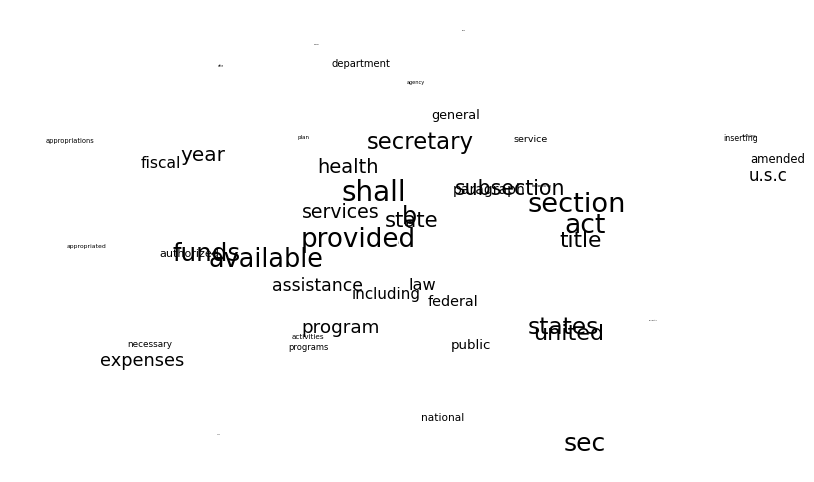

In [ ]:
# plot
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsne_words[:, 0], tsne_words[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(target_words):
    ax.annotate(word, (tsne_words[:, 0][i],tsne_words[:, 1][i]), size =  20 * (num_words - i) / num_words)
plt.xticks(())
plt.yticks(())
plt.show()

##### PCA

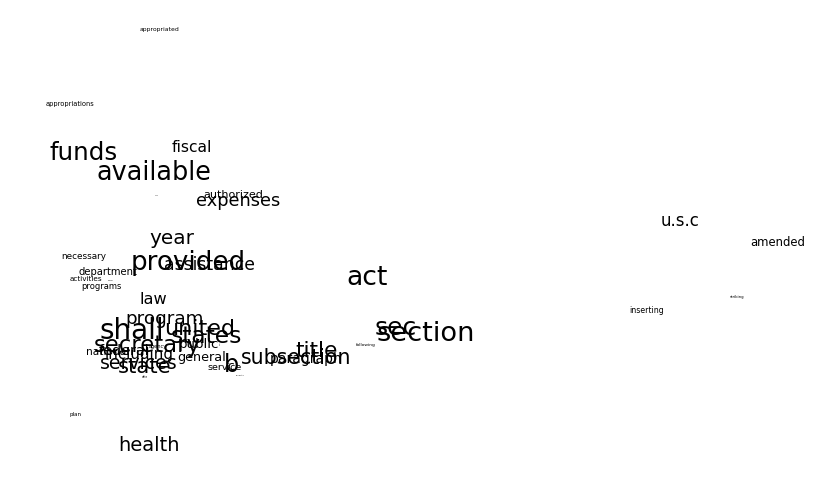

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_PCA_data[:, 0], reduced_PCA_data[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(target_words):
    ax.annotate(word, (reduced_PCA_data[:, 0][i],reduced_PCA_data[:, 1][i]), size =  20 * (num_words - i) / num_words)
plt.xticks(())
plt.yticks(())
plt.show()

### Reflection

- according to the CBOW Word2Vec, abortion and sterilization share contexts, which gives insight into some of the ways abortion has been used harmfully (against the person's will), which gives credence to anti-abortion arguments.

- in the skip-gram version of word to vector, the word closest to abortion is "shame," showing the rampant stigmatization of the practice.

- similarly, words similar to 'privacy', such as 'disclosure' and 'confidentiality' give credence to the medically sensitive nature of abortion and arguments to protect the procedure between willing patients and their doctors.

- in the skip-gram word2vec, STIs, STDs, and HPV are all associated with contraception, which could either indicate a negative association between the two (i.e., the pill doesn't protect against these diseases) or a positive association (condoms protect against these diseases).

- CBOW visualizations didn't give a lot of insight into the context of my corpus, but that could be due to the chosen words (the first 50 rather than a specific vocabulary)

- both versions of word2vec provide interesting insights into how the words in my corpora are organized.

### <font color="blue">*Exercise 2*</font>

<font color="blue">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

#### Build Doc2Vec Model

In [ ]:
congress_df_normwords = pd.read_csv(outpath + 'congress_legislation_tokenized.csv')

In [ ]:
congress_df_normwords['tokenized_text'] = congress_df_normwords['tokenized_text'].apply(lambda x: ast.literal_eval(x))
congress_df_normwords['normalized_tokens'] = congress_df_normwords['normalized_tokens'].apply(lambda x: ast.literal_eval(x))
congress_df_normwords['reduced_tokens'] = congress_df_normwords['reduced_tokens'].apply(lambda x: ast.literal_eval(x))

In [ ]:
congress_df_normwords = congress_df_normwords.loc[:, ['congress_num', 'legislation number', 'title', 'cleaned_summary', 'cleaned_text', 'tokenized_text', 'normalized_tokens', 'reduced_tokens']]
congress_df_normwords.head()

,congress_num,legislation number,title,cleaned_summary,cleaned_text,tokenized_text,normalized_tokens,reduced_tokens
0,118,H.R. 2907,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....,"[unit, Health, this, reproductive, competent, ...","[unit, competent, reproductive, energy, medica...","[unit, reproductive, energy, contract, ensure,..."
1,118,S. 1297,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....,"[unit, Health, this, reproductive, competent, ...","[unit, competent, reproductive, medically, con...","[unit, reproductive, contract, ensure, facilit..."
2,118,H.R. 4901,Reproductive Health Care Accessibility Act,Reproductive Health Care Accessibility Act Thi...,Congressional Bills 118th Congress From the U....,"[Health, this, best, date, reproductive, compe...","[best, date, reproductive, competent, florida,...","[reproductive, energy, contract, progress, ens..."
3,118,S. 2544,Reproductive Health Care Accessibility Act,Reproductive Health Care Accessibility Act Thi...,Congressional Bills 118th Congress From the U....,"[Health, this, best, date, reproductive, compe...","[best, date, reproductive, competent, energy, ...","[reproductive, energy, contract, progress, ens..."
4,118,H.R. 4147,Reproductive Health Care Training Act of 2023,NaN,Congressional Bills 118th Congress From the U....,"[Health, this, clinicians, reproductive, medic...","[fletcher, end, participants, clinicians, trai...","[participants, reproductive, energy, amounts, ..."


In [ ]:
taggedDocs = []
for index, row in congress_df_normwords.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [row['legislation number'], row['title']]
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_tokens'], tags = docKeywords))
congress_df_normwords['tagged_legislation'] = taggedDocs

In [ ]:
congress_df_normwords.head()

,congress_num,legislation number,title,cleaned_summary,cleaned_text,tokenized_text,normalized_tokens,reduced_tokens,tagged_legislation
0,118,H.R. 2907,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....,"[unit, Health, this, reproductive, competent, ...","[unit, competent, reproductive, energy, medica...","[unit, reproductive, energy, contract, ensure,...","([unit, competent, reproductive, energy, medic..."
1,118,S. 1297,Let Doctors Provide Reproductive Health Care Act,Let Doctors Provide Reproductive Health Care A...,Congressional Bills 118th Congress From the U....,"[unit, Health, this, reproductive, competent, ...","[unit, competent, reproductive, medically, con...","[unit, reproductive, contract, ensure, facilit...","([unit, competent, reproductive, medically, co..."
2,118,H.R. 4901,Reproductive Health Care Accessibility Act,Reproductive Health Care Accessibility Act Thi...,Congressional Bills 118th Congress From the U....,"[Health, this, best, date, reproductive, compe...","[best, date, reproductive, competent, florida,...","[reproductive, energy, contract, progress, ens...","([best, date, reproductive, competent, florida..."
3,118,S. 2544,Reproductive Health Care Accessibility Act,Reproductive Health Care Accessibility Act Thi...,Congressional Bills 118th Congress From the U....,"[Health, this, best, date, reproductive, compe...","[best, date, reproductive, competent, energy, ...","[reproductive, energy, contract, progress, ens...","([best, date, reproductive, competent, energy,..."
4,118,H.R. 4147,Reproductive Health Care Training Act of 2023,NaN,Congressional Bills 118th Congress From the U....,"[Health, this, clinicians, reproductive, medic...","[fletcher, end, participants, clinicians, trai...","[participants, reproductive, energy, amounts, ...","([fletcher, end, participants, clinicians, tra..."


In [ ]:
congress_d2v = gensim.models.doc2vec.Doc2Vec(documents=congress_df_normwords['tagged_legislation'], vector_size = 100) #Limiting to 100 dimensions


In [ ]:
# saving the model
congress_d2v.save(outpath + 'congress_d2v')

In [ ]:
congress_d2v['abortion']

array([ 0.99860096, -2.7324398 , -0.1321119 ,  0.5201029 , -2.5772808 ,
        1.3585103 ,  3.903234  ,  1.654012  , -1.8413334 ,  1.7397096 ,
       -3.2858033 , -1.3349166 ,  1.3958555 , -2.284003  , -4.315499  ,
       -2.0288868 ,  0.32105774, -0.16333304,  3.2776902 ,  0.7074284 ,
        3.6602235 , -0.10207532,  1.3794762 ,  0.85239816,  1.5460728 ,
        2.4259105 , -0.19496666, -3.027692  , -1.2650753 , -3.05091   ,
        1.8542193 ,  1.2249154 ,  1.1234301 , -0.28966463,  3.1452096 ,
        0.31923944, -1.0489624 ,  1.2084194 , -2.6627753 ,  2.0661304 ,
        1.0205382 ,  0.15435131, -1.9698079 , -1.6796819 ,  0.79009986,
       -0.90277135,  2.6218095 , -0.90437496,  2.4182272 ,  0.7309201 ,
       -1.6709584 ,  0.10510089,  2.8136978 ,  0.45912042,  0.39846468,
        0.7109754 ,  0.13195828, -1.7133394 , -3.7264535 ,  3.8301878 ,
        1.37836   ,  3.6472163 ,  0.71503854,  0.9493763 , -3.6805556 ,
        0.5672015 ,  2.3769689 ,  3.4549303 , -1.4297609 ,  2.45

#### Examining word vectors

In [ ]:
# find the top documents related to reproductive
congress_d2v.docvecs.most_similar([ congress_d2v['reproductive'] ], topn=5 )

[('H.R. 435', 0.846847414970398),
 ('H.R. 611', 0.8272448182106018),
 ('Global Sexual and Reproductive Health Act of 2010', 0.811440646648407),
 ('H.R. 5121', 0.8113349676132202),
 ('S. 701', 0.8077537417411804)]

In [ ]:
congress_df_normwords.loc[congress_df_normwords.loc[:, 'legislation number'].isin(['H.R. 435', 'H.R. 611', 'H.R. 5121', 'S. 701']), 'title']

52                 Women’s Health Protection Act of 2023
67         Protecting Life on College Campus Act of 2023
284           Child Interstate Abortion Notification Act
674    Global Sexual and Reproductive Health Act of 2010
Name: title, dtype: object

In [ ]:
# find the top documents related to infanticide
congress_d2v.docvecs.most_similar([ congress_d2v['infanticide'] ], topn=5 )

[('S. 105', 0.653548538684845),
 ('S. 133', 0.6486306190490723),
 ('No Taxpayer Funding for Abortion and Abortion Insurance Full Disclosure Act of 2023',
  0.6206489205360413),
 ('S. 1673', 0.616359293460846),
 ('S. 906', 0.6131302714347839)]

In [ ]:
list(congress_df_normwords.loc[congress_df_normwords.loc[:, 'legislation number'].isin(['S. 105', 'S. 133', 'S. 1673', 'S. 906']), 'title'])

['Title X Abortion Provider Prohibition Act',
 'Intelligence Authorization Act for Fiscal Year 2017',
 'No Taxpayer Funding for Abortion Act',
 'Unborn Victims of Violence Act of 1999']

In [ ]:
# find the top documents related to infanticide
congress_d2v.docvecs.most_similar([ congress_d2v['autonomy'] ], topn=5 )

[('S. 105', 0.834003210067749),
 ('H.R. 4796', 0.8179441094398499),
 ('H.R. 3610', 0.7972944378852844),
 ('Parental Notification and Intervention Act of 2017', 0.7943722009658813),
 ('H.R. 3900', 0.7926015853881836)]

In [ ]:
list(congress_df_normwords.loc[congress_df_normwords.loc[:, 'legislation number'].isin(['S. 105', 'H.R. 4796', 'H.R. 3610', 'H.R. 3900']), 'title'])

['Reproductive Health Patient Navigator Act of 2023',
 'Parental Notification and Intervention Act of 2021',
 'Title X Abortion Provider Prohibition Act',
 'Omnibus Consolidated Appropriations Act, 1997']

In [ ]:
# finding words closest to 'No Taxpayer Funding for Abortion and Abortion Insurance Full Disclosure Act of 2023'
congress_d2v.wv.most_similar( [ congress_d2v.docvecs['No Taxpayer Funding for Abortion and Abortion Insurance Full Disclosure Act of 2023'] ], topn=10)

[('renacci', 0.8017705082893372),
 ('boustany', 0.779619038105011),
 ('violate', 0.7696955800056458),
 ('homo', 0.7584220170974731),
 ('fischbach', 0.7575352191925049),
 ('discrimination', 0.7560210227966309),
 ('intentional', 0.7503612637519836),
 ('incidence', 0.7466430068016052),
 ('punitive', 0.7465892434120178),
 ('spouses', 0.7459473013877869)]

In [ ]:
# finding words closests to 'S. 906' - 'Unborn Victims of Violence Act of 1999'
congress_d2v.wv.most_similar( [ congress_d2v.docvecs['S. 906'] ], topn=10)

[('rip', 0.8907967209815979),
 ('renacci', 0.8850952982902527),
 ('endometrial', 0.8603261113166809),
 ('southerland', 0.8594567775726318),
 ('bentsen', 0.8559130430221558),
 ('anesthetics', 0.8374515771865845),
 ('application', 0.8365612030029297),
 ('finds', 0.8345703482627869),
 ('lacey', 0.8317352533340454),
 ('johnson', 0.830310583114624)]

In [ ]:
# looking for legislations that combine privacy, abortion, choice, and freedom
congress_d2v.docvecs.most_similar([ congress_d2v['defend']+congress_d2v['choice']+congress_d2v['woman']], topn=5 )

[('Parental Notification and Intervention Act of 2017', 0.9224056005477905),
 ('H.R. 2956', 0.9214112758636475),
 ('Pregnant Women Health and Safety Act of 2020', 0.9096590876579285),
 ('S. 4541', 0.9064081907272339),
 ('China Trade Relations Act of 2022', 0.9049842953681946)]

In [ ]:
list(congress_df_normwords.loc[congress_df_normwords.loc[:, 'legislation number'].isin(['H.R. 2956', 'S. 4541',]), 'title'])

['Standing with Moms Act',
 'Parental Notification and Intervention Act of 2017',
 'Crime Prevention Act of 1995',
 'Cancer Registries Amendment Act']

### Visualization

In [ ]:
rand_indices = random_indices(len(congress_df_normwords), 10)

In [ ]:
congress_df_normwords.loc[rand_indices, ['title', 'legislation number']]

,title,legislation number
18,Child Interstate Abortion Notification Act,H.R. 792
154,No Taxpayer Funds for Illegal Alien Abortions Act,H.R. 9575
314,Woman’s Right To Know Act,S. 3388
414,"Consolidated Appropriations Act, 2017",H.R. 244
427,Equal Access to Abortion Coverage in Health In...,H.R. 2972
557,District of Columbia Pain-Capable Unborn Child...,S. 886
584,"Commerce, Justice, Science, and Related Agenci...",S. 2437
610,Ultrasound Informed Consent Act,H.R. 3805
827,Informed Choice Act,S. 340
828,Informed Choice Act,H.R. 195


In [ ]:
# Visualizing the similarity of the first 10 documents in the corpus
targetDocs = congress_df_normwords.loc[rand_indices, 'legislation number']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = congress_d2v.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, congress_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

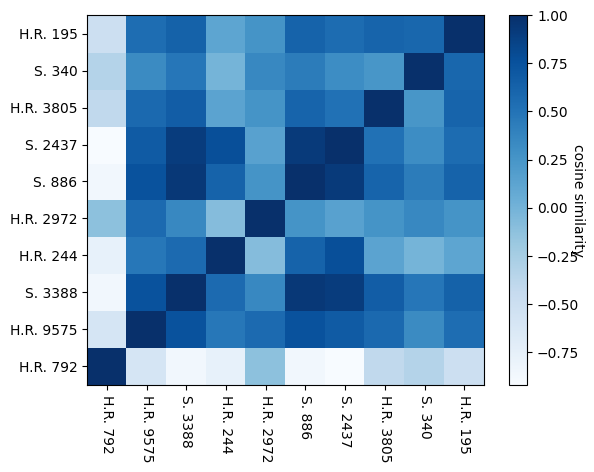

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='Blues')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

### Reflection
- many of the documents in my corpus are denoted as similar or sharing similar contexts, maybe indicating a lack of extreme change over the years in how the abortion argument has been framed within legislation
- there are multiple legislations about preventing abortion or protecting fetuses, but fewer that are overtly protecting the practice
- based on the calculation of words closest to specific documents, doc2vec seems like an excellent method for determining what politicians were involved with what legislations


### <font color="blue">*Exercise 3*</font>

<font color="blue">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why?

<font color="blue">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

#### Create Dimensions

In [ ]:
# creating political affiliation dimension
gender = dimension(congress_w2v, ['man', 'male'], ['woman', 'female'])
race = dimension(congress_w2v, ['black','blacks',], ['white', 'whites'])
class_ = dimension(congress_w2v, ['rich', 'expensive', 'wealth'], ['poor', 'poverty', 'cheap', 'inexpensive'])


In [ ]:
roles = ['person', 'mother', 'baby', 'fetus', 'child', 'doctor', 'midwife', 'nurse', 'physician', 'provider']

In [ ]:
actions = ['choose', 'kill', 'murder', 'save', 'protect', 'abort', 'birth']

In [ ]:
methods = ['procedure', 'operation', 'abortion', 'contraception', 'fertilization']

#### Embed classes on dimensions

In [ ]:
def makeDF(model, word_list, dimensions, dimension_names):
    data = {}
    for dimension, name in zip(dimensions, dimension_names):
      data[name] = []
      for word in word_list:
          data[name].append(sklearn.metrics.pairwise.cosine_similarity(model.wv[word].reshape(1,-1), dimension.reshape(1,-1))[0][0])

    df = pd.DataFrame(data, index = word_list)
    return df

In [ ]:
roles_df = makeDF(congress_w2v, roles, [race, gender, class_], ['race', 'gender', 'class'])

In [ ]:
actions_df = makeDF(congress_w2v, actions, [race, gender, class_], ['race', 'gender', 'class'])

In [ ]:
methods_df = makeDF(congress_w2v, methods, [race, gender, class_], ['race', 'gender', 'class'])

#### Visualize

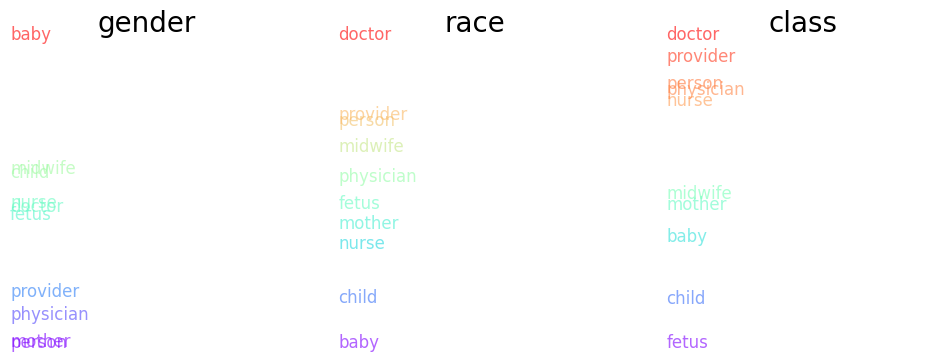

In [ ]:
# roles
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, roles_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, roles_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, roles_df, 'class')
plt.show()

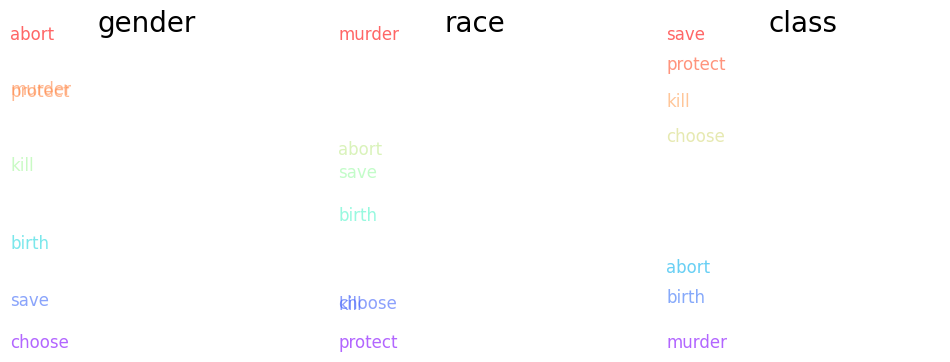

In [ ]:
# actions
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, actions_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, actions_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, actions_df, 'class')
plt.show()

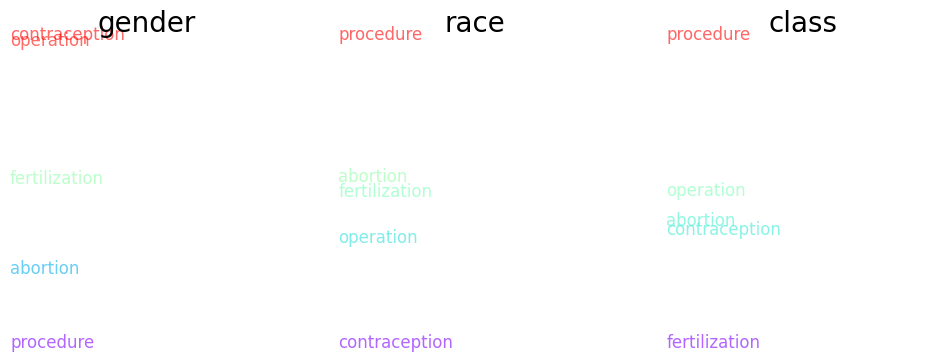

In [ ]:
# methods
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, methods_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, methods_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, methods_df, 'class')
plt.show()

#### Reflection
Since legislation is so rigid in terms of the allowable language used, there are not obvious dimensions on which to project my vectors. Instead, I opted to include the dimensions from the example (race, gender, class), and even then, some of the simple word vectors used in the example ('he', 'she', etc.) were not present in my dataset. Regardless, I projected vectors corresponding to reproductive healthcare actions, roles, and procedures onto these dimensions, and found that they similarly described the variation in these vectors.

### <font color="blue">*Exercise 4*</font>

<font color="blue">Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space?

#### Visualize Temporal Data

In [26]:
congress_count_df = congress_df.groupby('congress_num', as_index=False).agg({'legislation number': 'count'}).sort_values(by=['congress_num']).rename(columns={'legislation number': 'num_bills'})
congress_count_df

,congress_num,num_bills
0,101,49
1,102,60
2,103,38
3,104,72
4,105,53
5,106,60
6,107,47
7,108,55
8,109,45
9,110,43


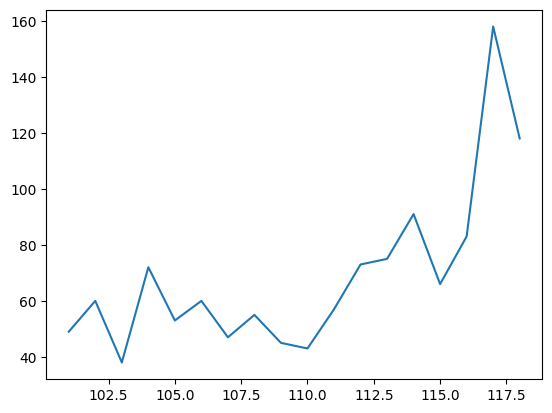

In [28]:
plt.plot(congress_count_df['congress_num'], congress_count_df['num_bills'])

#### Create Embeddings

In [67]:
# generate embeddings
rawEmbeddings, comparedEmbeddings = compareModels(congress_df, 'congress_num')

In [68]:
rawEmbeddings.keys()

dict_keys([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118])

#### Compare Embeddings across Permutations

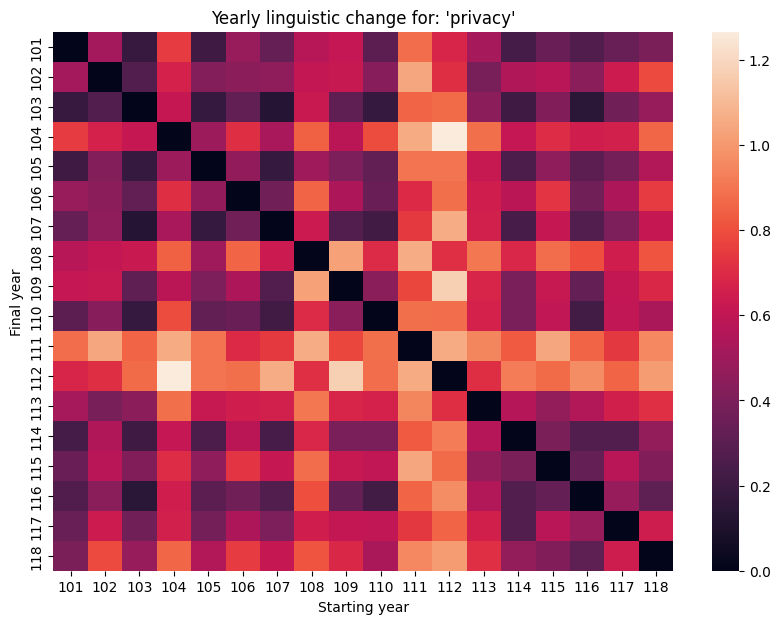

In [83]:
# compare across permutations
targetWord = 'privacy'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

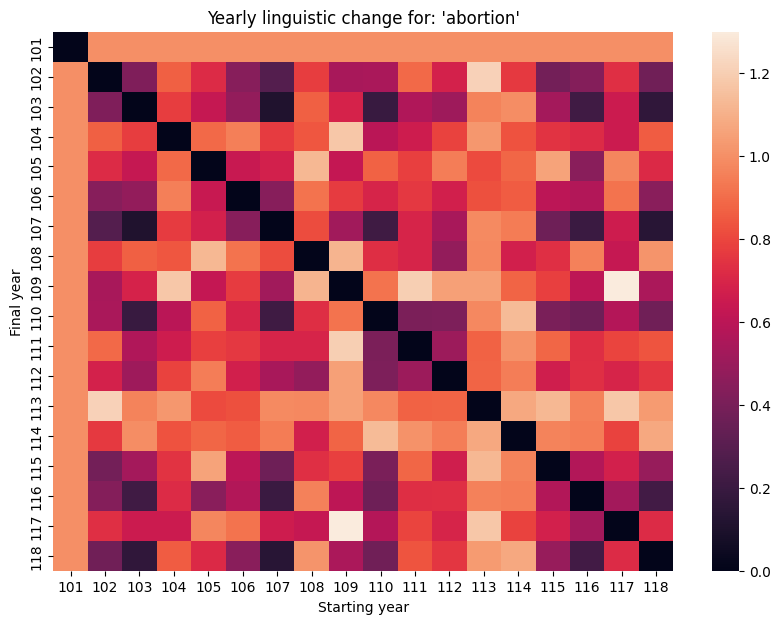

In [84]:
targetWord = 'abortion'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

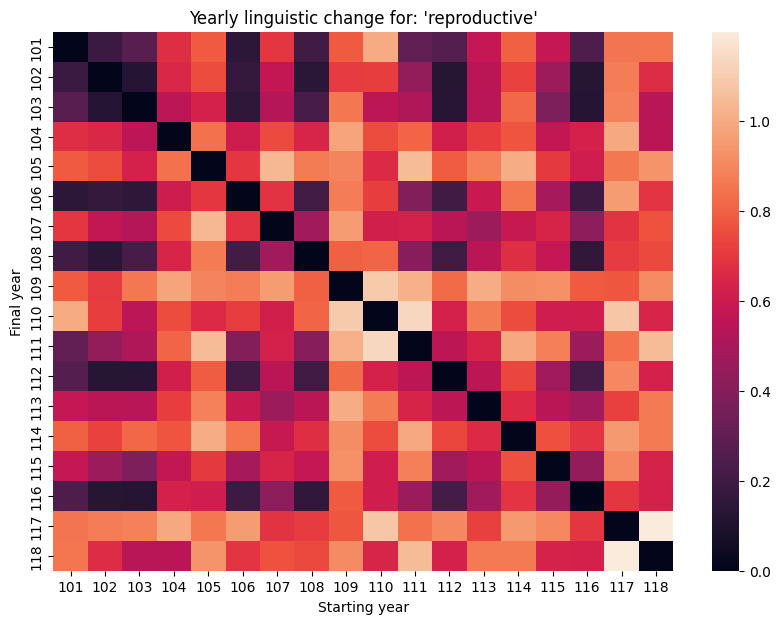

In [89]:
targetWord = 'reproductive'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

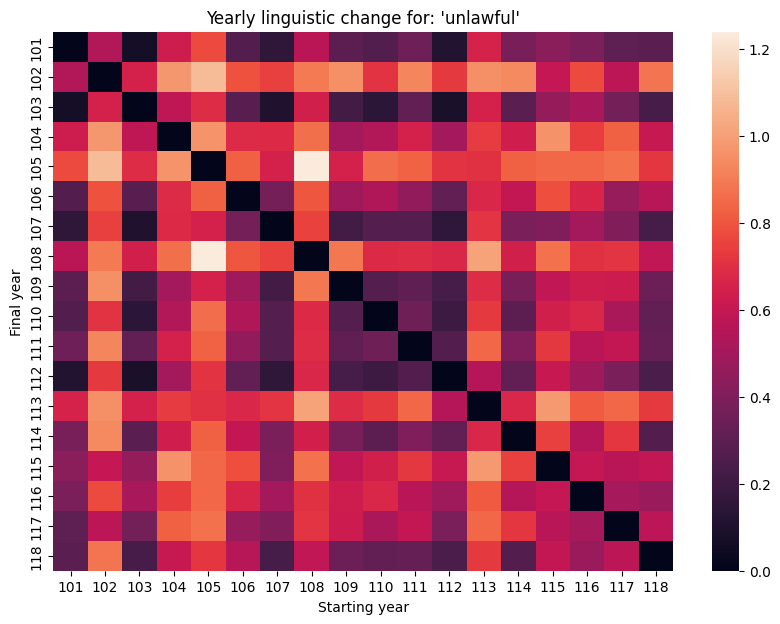

In [91]:
targetWord = 'unlawful'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

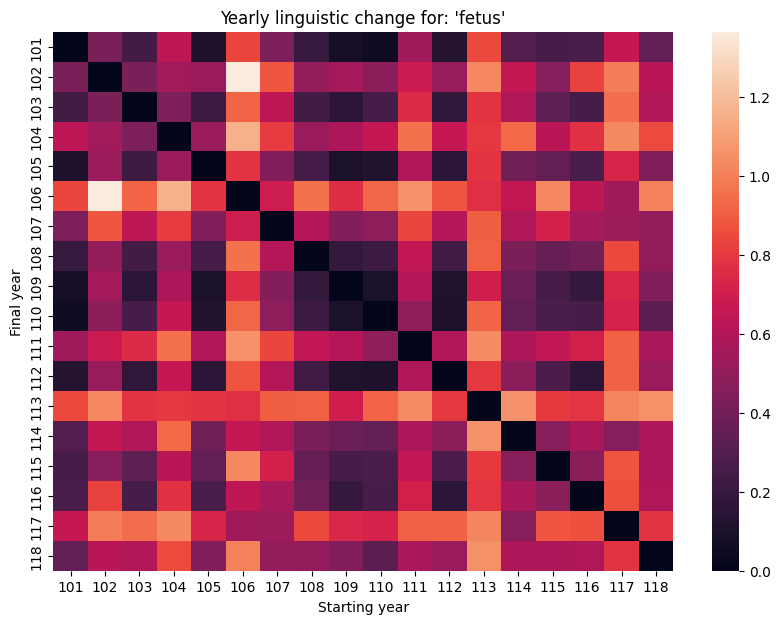

In [92]:
targetWord = 'fetus'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

#### Find Text Divergences

In [112]:
wordDivergences = findMostDivergent(comparedEmbeddings, 101)

Found 1915 words to compare


In [119]:
# most divergent words
wordDivergences[:20]

[('app', 1.083611911162734),
 ('reorganization', 1.066710193436045),
 ('report', 0.9999999999999993),
 ('b', 0.9999999999999991),
 ('ii', 0.9999999999999991),
 ('health', 0.999999999999999),
 ('u.s.c', 0.999999999999999),
 ('title', 0.999999999999999),
 ('services', 0.9999999999999986),
 ('authorized', 0.9999999999999977),
 ('defense', 0.9999999999999974),
 ('paragraph', 0.9999999999999973),
 ('act', 0.9999999999999967),
 ('purposes', 0.9999999999999967),
 ('respect', 0.9999999999999962),
 ('state', 0.9999999999999962),
 ('funds', 0.999999999999996),
 ('foreign', 0.999999999999996),
 ('assistance', 0.999999999999996),
 ('government', 0.9999999999999958)]

In [114]:
# least divergent words
wordDivergences[-20:]

[('requests', 0.3355655214365791),
 ('offer', 0.3341055021566503),
 ('west', 0.3326301714953254),
 ('litigation', 0.3276900410213891),
 ('printed', 0.3251125768703573),
 ('arising', 0.323292076587677),
 ('targeted', 0.32014355216832724),
 ('placed', 0.31991154481382933),
 ('contractors', 0.31665796479758096),
 ('giving', 0.3165128783268087),
 ('penalties', 0.3161293888081084),
 ('accept', 0.3146778345108032),
 ('characteristics', 0.31252479553222656),
 ('birth', 0.30760008447310505),
 ('past', 0.3039509706637439),
 ('informed', 0.30162330059444203),
 ('open', 0.3005976771168849),
 ('elimination', 0.29121125971569733),
 ('n', 0.29036756867871566),
 ('significantly', 0.27255846121731925)]

#### Visualizations

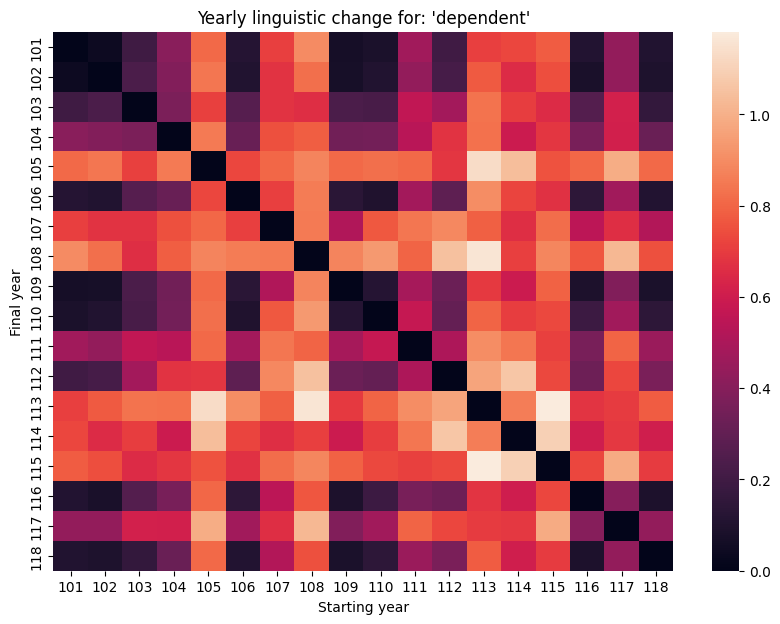

In [115]:
targetWord = wordDivergences[-200][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

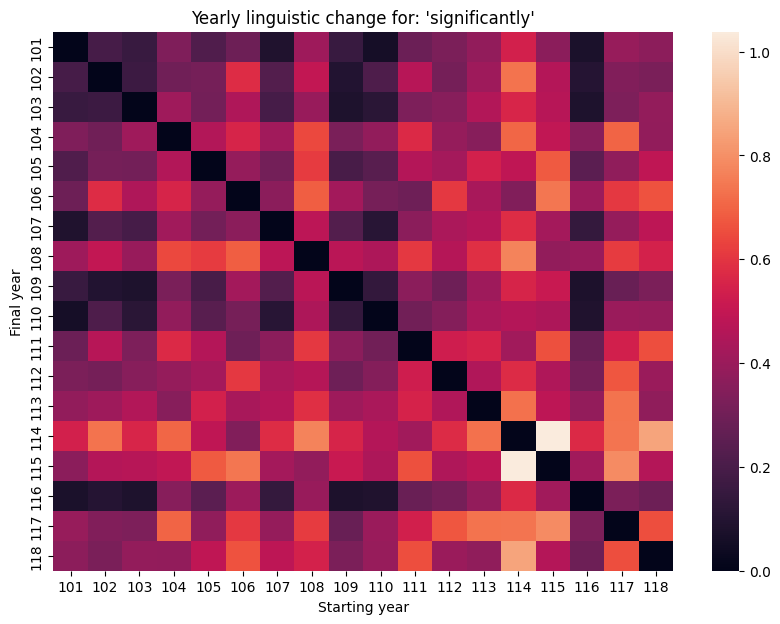

In [116]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

#### Reflection
- in terms of word divergences, even the least significant divergences had a divergence rate of at least 30%, showing how rapidly language used in legislation changes over time.
- the most divergent words in part have to do with technological changes over time (app), and others instead seem to reflect changes in broad U.S. conversations (foreign, defense, health, etc.).
- these findings seem to indicate that although the legislation is abortion specific, it still reflects broad trends in the U.S.